In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Stroke Prediction Using Machine Learning
### Li-Chia Chen

## I. Introduction
Stroke is the fifth cause of death in the United States, according to the Heart Disease and Stroke Statistics 2020 report. Those who suffer from stroke, if luckily survived, may also suffer from expensive medical bills and even disability. Foreseeing the underlying risk factors of stroke is highly valuable to stroke screening and prevention. In this project, the National Health and Nutrition Examination Survey (NHANES) data from the National Center for Health Statistics (NCHS) is used to develop machine learning models. The NHANES dataset holds an abundance of variables, ranging from demographics, medical history, physical examinations, biochemistry to dietary and lifestyle questionnaires. Known features contributing to stroke, such as blood pressure, serum cholesterol level, alcohol consumption, weight, etc., and additional features will be selected for correlation evaluation and machine learning model development. 

Main elements include data cleaning, imbalance dataset processing, feature selection from over 1,000 variables, and model training.

In [2]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## II. Data Loading and Cleaning
### Datasets
- NHANES Datasets from 2013-2014<br><br>
https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey
<br><br>
- Variable Search<br><br>
https://wwwn.cdc.gov/nchs/nhanes/search/default.aspx
<br><br>
- Codebook<br><br>
https://wwwn.cdc.gov/nchs/nhanes/Search/DataPage.aspx?Component=Demographics&CycleBeginYear=2013
<br><br>


In [3]:
# datasets path and df names
path = [
    'dataset\\demographic.csv',
    'dataset\\examination.csv',
    'dataset\\questionnaire.csv',
    'dataset\\labs.csv',
    'dataset\\diet.csv'  
]

dfname = [
    'dm',
    'exam',
    'qs',
    'lab',
    'diet'
]

In [4]:
# import datasets as dfs

df = {}
dfn = dict(zip(dfname, path))
df = {key: pd.read_csv(value) for key, value in dfn.items()}

In [5]:
Xs = {k: v for k, v in df.items() if k in ['dm', 'exam', 'labs']}

dfs = Xs.values()

from functools import partial, reduce 
inner_merge = partial(pd.merge, how='inner', on='SEQN') 

c = reduce(inner_merge, dfs)
c

# check if there are duplicated SEQN
c.SEQN.duplicated().value_counts()


False    9813
Name: SEQN, dtype: int64

In [6]:
# show combined df
qs = df['qs'][['SEQN','MCQ160F']]
qs

,SEQN,MCQ160F
0,73557,1.0
1,73558,2.0
2,73559,2.0
3,73560,NaN
4,73561,2.0
...,...,...
10170,83727,2.0
10171,83728,NaN
10172,83729,2.0
10173,83730,NaN


In [7]:
c = pd.merge(c,qs, how='left', on='SEQN')
c

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,CSXSOAOD,CSXGRAOD,CSXONOD,CSXNGSOD,CSXSLTRT,CSXSLTRG,CSXNART,CSXNARG,CSAEFFRT,MCQ160F
0,73557,8,2,1,69,NaN,4,4,1.0,NaN,...,1.0,1.0,1.0,4.0,62.0,1.0,NaN,NaN,1.0,1.0
1,73558,8,2,1,54,NaN,3,3,1.0,NaN,...,1.0,2.0,3.0,4.0,28.0,1.0,NaN,NaN,1.0,2.0
2,73559,8,2,1,72,NaN,3,3,2.0,NaN,...,1.0,2.0,3.0,4.0,49.0,1.0,NaN,NaN,3.0,2.0
3,73560,8,2,1,9,NaN,3,3,1.0,119.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,73561,8,2,2,73,NaN,3,3,1.0,NaN,...,1.0,4.0,3.0,4.0,NaN,NaN,NaN,NaN,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9808,83727,8,2,1,26,NaN,2,2,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
9809,83728,8,2,2,2,24.0,1,1,2.0,24.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9810,83729,8,2,2,42,NaN,4,4,2.0,NaN,...,1.0,1.0,3.0,4.0,55.0,1.0,NaN,NaN,3.0,2.0
9811,83730,8,2,1,7,NaN,2,2,1.0,84.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
c.MCQ160F.value_counts()

2.0    5389
1.0     194
9.0       5
Name: MCQ160F, dtype: int64

### Exclude rows with null values or NA for MCQ160F
The prediction target in the dataset is MCQ160F, a questionnaire question "Has a doctor or other health professional ever told you that you had a stroke?"


In [9]:
# MCQ160F (target feature): exclude null values and NA
c = c[(c.MCQ160F.notnull()) & (c.MCQ160F != 9)]

# check MCQ160F
c.MCQ160F.describe()

count    5583.000000
mean        1.965252
std         0.183158
min         1.000000
25%         2.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: MCQ160F, dtype: float64

In [10]:
# target varoable counts
c.MCQ160F.value_counts()

2.0    5389
1.0     194
Name: MCQ160F, dtype: int64

### Codebook
- Codebook with variable and sas label parsed with Beautiful Soup:
https://www.kaggle.com/lcchennn/nhanes-2013-2014-codebook-with-sas-label

In [11]:
# import code book
cbook = pd.read_csv('dataset\\nhanes_2013_2014_codebook.csv')

cbook

,variable,label
0,SEQN,Respondent sequence number
1,SDDSRVYR,Data release cycle
2,RIDSTATR,Interview/Examination status
3,RIAGENDR,Gender
4,RIDAGEYR,Age in years at screening
...,...,...
3901,WHD140,Self-reported greatest weight (pounds)
3902,WHQ150,Age when heaviest weight
3903,WHQ030M,How do you consider your weight
3904,WHQ500,Trying to do about weight


### Data Cleaning

In [12]:
# exclude non-numeric values
d = c.select_dtypes(['number'])

# exclue columns that have over 50% NaN
d = d.dropna(thresh = 0.5*len(d), axis =1)

print(len(d.columns), 'columns left')

153 columns left


In [13]:
# changing target variable coding from 1, 2 to 0 (Negative), 1 (Positive)
d['MCQ160F']=d.apply(lambda x: 1 if x.MCQ160F == 1 else 0, axis='columns')
d.MCQ160F.value_counts()

0    5389
1     194
Name: MCQ160F, dtype: int64

## III. Feature Selection
Reference: 
A data-driven approach to predicting diabetes and cardiovascular disease with machine learning<br><br>
https://pubmed.ncbi.nlm.nih.gov/31694707/

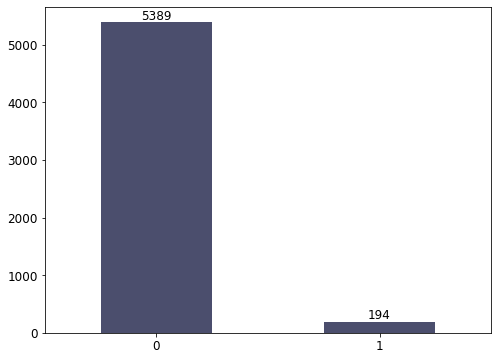

In [14]:
vals = d.MCQ160F.value_counts()

plt.figure(figsize=(8,6))
plt.rc('font', size=12)

ax = vals.plot.bar(rot=0, color='#4B4E6D')

for i in range(len(vals)):
    ax.annotate(vals[i], xy=[vals.index[i], vals[i]], ha='center', va='bottom')

In [15]:
from sklearn.impute import SimpleImputer
imp_mode=SimpleImputer(strategy='most_frequent')

d = pd.DataFrame(imp_mode.fit_transform(d), columns=d.columns)

### Train/Test Split

In [16]:
X = d.loc[:, d.columns != 'MCQ160F']
y = d.MCQ160F

In [17]:
print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (5583, 152)
y shape: (5583,)


In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

### XGBClassifier for feature selection
From the classificaiton result, the accuracy is pretty decent. However once look into the confusion matrix we can see there is only 1 correct prediction for class 1 (recall for class 1 is bad). This is commonly seen for imbalanced dataset, which the classes in the dataset have highly uneven sample sizes. Imbalanced problems is often seen in healthcare  datasets.

In [20]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

def confusion(y_test, y_pred):
    conf = pd.DataFrame(confusion_matrix(y_test, y_pred), index=['True[0]', 'True[1]'], columns=['Predict[0]', 'Predict[1]'])
    print('Confusion Matrix:')
    print(conf)
    return conf

confusion(y_test, y_pred)

D:\anaconda\envs\ReconNet\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:57:08] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 96.33%
Confusion Matrix:
         Predict[0]  Predict[1]
True[0]        1075           1
True[1]          40           1


,Predict[0],Predict[1]
True[0],1075,1
True[1],40,1


### Upsampling minority class
In the following cells the minority class is upsampled with SMOTE (Synthetic Minority Oversampling Technique).

In [21]:
y_test.value_counts()


0.0    1076
1.0      41
Name: MCQ160F, dtype: int64

#### Oversampling with SMOTE

In [27]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_sm, y_train_sm = smote.fit_sample(X_train, y_train)
X_test_sm, y_test_sm = smote.fit_sample(X_test, y_test)

X_train_sm = pd.DataFrame(X_train_sm, columns=X.columns)
X_test_sm = pd.DataFrame(X_test_sm, columns=X.columns)

AttributeError: 'SMOTE' object has no attribute 'fit_sample'

In [28]:
import imblearn
print(imblearn.__version__)

0.8.1


In [ ]:
print(y_train_sm.value_counts())
print(y_test_sm.value_counts())

#### Check the Classification Result Again
After oversampling, the classification result is more reasonable.

In [ ]:
model = XGBClassifier()
model.fit(X_train_sm, y_train_sm)
y_pred_sm = model.predict(X_test_sm)

accuracy = accuracy_score(y_test_sm, y_pred_sm)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
conf = pd.DataFrame(confusion_matrix(y_test_sm, y_pred_sm), index=['True[0]', 'True[1]'], columns=['Predict[0]', 'Predict[1]'])
conf

### Feature Selection with XGBoost

In [ ]:
from xgboost import XGBClassifier
from matplotlib import pyplot

# fit model no training data
model = XGBClassifier()
model.fit(X_train_sm, y_train_sm)

# Features selected by XGBoost
keys = list(model.get_booster().feature_names)
values = list(model.feature_importances_)

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)

# Top 24 features
xgbfs_ = data[:24]

# Plot feature score
xgbfs_.sort_values(by='score').plot(kind='barh', figsize=(10, 8), color='#4B4E6D')


In [ ]:
xgbfs_.reset_index()

### Merge SAS Labels from the codebook

In [ ]:
xgbfs = xgbfs_.reset_index()
xgbfs.columns=['variable', 'score']

xgbfs['variable'] = xgbfs['variable'].apply(lambda x: x.upper())

xgbfs = pd.merge(left=xgbfs, right=cbook, left_on='variable', right_on='variable', how='left')
xgbfs

In [ ]:
# final variables
var_list = xgbfs.variable.tolist()
var_list.append('MCQ160F')
print(var_list)

In [ ]:
#final df
df_final = d.filter(var_list)
df_final

In [ ]:
# sns.axes_style("white")
ax = plt.subplots(figsize=(20,20))

corr = df_final.corr()

# sns.heatmap(corr, vmin=-1, vmax=1, cmap=sns.cm.rocket_r)
sns.heatmap(corr, cmap=sns.cm.rocket_r)

## IV. Model Training

### Train/Test Split

In [ ]:
X_ = df_final.loc[:, df_final.columns != 'MCQ160F']
y = df_final.MCQ160F

### Data Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler

minmax=MinMaxScaler()
X = pd.DataFrame(minmax.fit_transform(X_), columns=X_.columns)
X

### Upsampling Minoroty Class with SMOTE
Note that it is important to only oversample after train/test split, so the testing data will not leak.

In [ ]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11)

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_sm, y_train_sm = smote.fit_sample(X_train, y_train)
# X_test_sm, y_test_sm = smote.fit_sample(X_test, y_test)

X_train_sm = pd.DataFrame(X_train_sm, columns=X.columns)
# X_test_sm = pd.DataFrame(X_test_sm, columns=X.columns)

In [ ]:
print('X train shape: ',X_train_sm.shape)
print('y train values: \n', y_train_sm.value_counts())
print()
print('X test shape: ',X_test.shape)
print('y test values: \n', y_test.value_counts())

In [ ]:
mscore=[]

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=100, solver='lbfgs', class_weight='balanced', random_state=11).fit(X_train_sm, y_train_sm)
y_pred = clf.predict(X_test)

print('Accuracy Score:', clf.score(X_test, y_test))
print('Prediction:', y_pred)

mscore.append(['Logistic Regression', clf.score(X_test, y_test)])

print(classification_report(y_test, y_pred))
confusion(y_test, y_pred)

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=150, criterion='gini', max_depth=5, random_state=11)
rnd_clf.fit(X_train_sm, y_train_sm)

y_pred = rnd_clf.predict(X_test)

print('Accuracy Score:', rnd_clf.score(X_test, y_test))
print('Prediction:', y_pred)

mscore.append(['Random Forest', rnd_clf.score(X_test, y_test)])

print(classification_report(y_test, y_pred))
confusion(y_test, y_pred)

### Gradient Boosting Decision Trees

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(learning_rate=0.1, n_estimators=10, random_state=11)
gbc.fit(X_train_sm, y_train_sm)

y_pred = gbc.predict(X_test)

print('Accuracy Score:', gbc.score(X_test, y_test))
print('Prediction:', y_pred)

mscore.append(['GradientBoosting', gbc.score(X_test, y_test)])

print(classification_report(y_test, y_pred))
confusion(y_test, y_pred)

### AdaBoostClassifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(learning_rate=0.01, n_estimators=30, random_state=11)
ada.fit(X_train_sm, y_train_sm)

y_pred = ada.predict(X_test)

print('Accuracy Score:', ada.score(X_test, y_test))
print('Prediction:', y_pred)

mscore.append(['Adaptive Boosting', ada.score(X_test, y_test)])

# from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
confusion(y_test, y_pred)

### SVM

In [ ]:
from sklearn.svm import SVC
svm_clf = SVC(kernel='sigmoid', gamma='auto', random_state=11)
svm_clf.fit(X_train_sm, y_train_sm)
y_pred = svm_clf.predict(X_test)

print('Accuracy Score:', svm_clf.score(X_test, y_test))
print('Prediction:', y_pred)

mscore.append(['SVM', svm_clf.score(X_test, y_test)])

# from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
confusion(y_test, y_pred)

### XGBoost

In [ ]:
from xgboost import XGBClassifier

xgbc = XGBClassifier(eta=0.01, max_depth=3)
# xgbc = XGBClassifier(eta=0.01)
xgbc.fit(X_train_sm, y_train_sm)

y_pred = xgbc.predict(X_test)

print('Accuracy Score:', svm_clf.score(X_test, y_test))
print('Prediction:', y_pred)

mscore.append(['XGBoost', xgbc.score(X_test, y_test)])

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
confusion(y_test, y_pred)

## V. Model Comparison

In [ ]:
mscore.sort(key=lambda x: x[1], reverse=True)
mscore

In [ ]:
model = list(i[0] for i in mscore)
score = list(round(i[1]*100,2) for i in mscore)

print('Accracy Score: \n')
for m,s in zip(model, score):
    print(f'{m}: {s}%')
  
 
# creating horizontal bar plot
plt.barh(model, score, height = 0.5, color='#4B4E6D') # this color is called independence, how cool!
 
plt.xlabel("Accuracy Score")
plt.ylabel("Model")
plt.title("Model Comparison")
plt.gca().invert_yaxis()
plt.show()

## VI. Future Work
1. Model optimization/hyperparameter tuning
2. Ensamble
3. ROC/AUC comparison
